In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xesmf as xe
import geopandas as gpd
import shapely.geometry as geom
import matplotlib as mpl
import regionmask

In [4]:
datapath = f'/g/data/ng72/as9583/cylc-run/u-dr216/netcdf'
variable = 'stratiform_rainfall_flux' #variable
experiment = 'drysoil_d0198_RAL3P2_albedo_bare_' #experiment name

da1 = xr.open_dataset(f'{datapath}/{variable}/{experiment}{variable}.nc')[variable]

da1_local = da1.copy()
da1_local['time'] = da1['time'] + pd.Timedelta(hours=10) #convert to AEST 

variable3 = 'land_sea_mask'
landmask = xr.open_dataset(f'{datapath}/{variable3}/{experiment}{variable3}.nc')["land_binary_mask"].isel(time=0)

da1_local= da1_local.where(landmask == 1)

In [5]:
datapath2 = f'/g/data/ng72/as9583/cylc-run/u-dr216/netcdf'
variable2 = 'surface_altitude'
experiment2 = 'control_d0198_RAL3P2_' #experiment name
sa1 = xr.open_dataset(f'{datapath2}/{variable2}/{experiment2}{variable2}.nc')[variable2].isel(time=0)

In [6]:
rainfall = xr.open_dataset("/g/data/ng72/as9583/agcd_v1_precip_calib_r005_daily_2020.nc") #agcd data
fires = gpd.read_file('/g/data/ng72/as9583/merged_fires.gpkg')

In [7]:
#regrid to model total
regridder = xe.Regridder(da1_local, rainfall, 'conservative')
model_total = regridder(da1_local, keep_attrs=True)

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: gadi-cpu-bdw-0101
--------------------------------------------------------------------------


In [8]:
#model
lat_model = da1_local['latitude']
lon_model = da1_local['longitude']

#agcd
lat_obs = rainfall['lat']
lon_obs = rainfall['lon']

lat_min = max(lat_model.min().item(), lat_obs.min().item())
lat_max = min(lat_model.max().item(), lat_obs.max().item())
lon_min = max(lon_model.min().item(), lon_obs.min().item())
lon_max = min(lon_model.max().item(), lon_obs.max().item())

print("Overlap region:")
print(f"Latitude: {lat_min} to {lat_max}")
print(f"Longitude: {lon_min} to {lon_max}")

Overlap region:
Latitude: -37.95500183105469 to -29.064802169799805
Longitude: 146.0449981689453 to 154.93519592285156


In [9]:
model_clipped = da1_local.sel(
    latitude=slice(lat_min, lat_max),
    longitude=slice(lon_min, lon_max)
)

rainfall_clipped = rainfall.sel(
    lat=slice(lat_min, lat_max),
    lon=slice(lon_min, lon_max)
)

## Model resolution

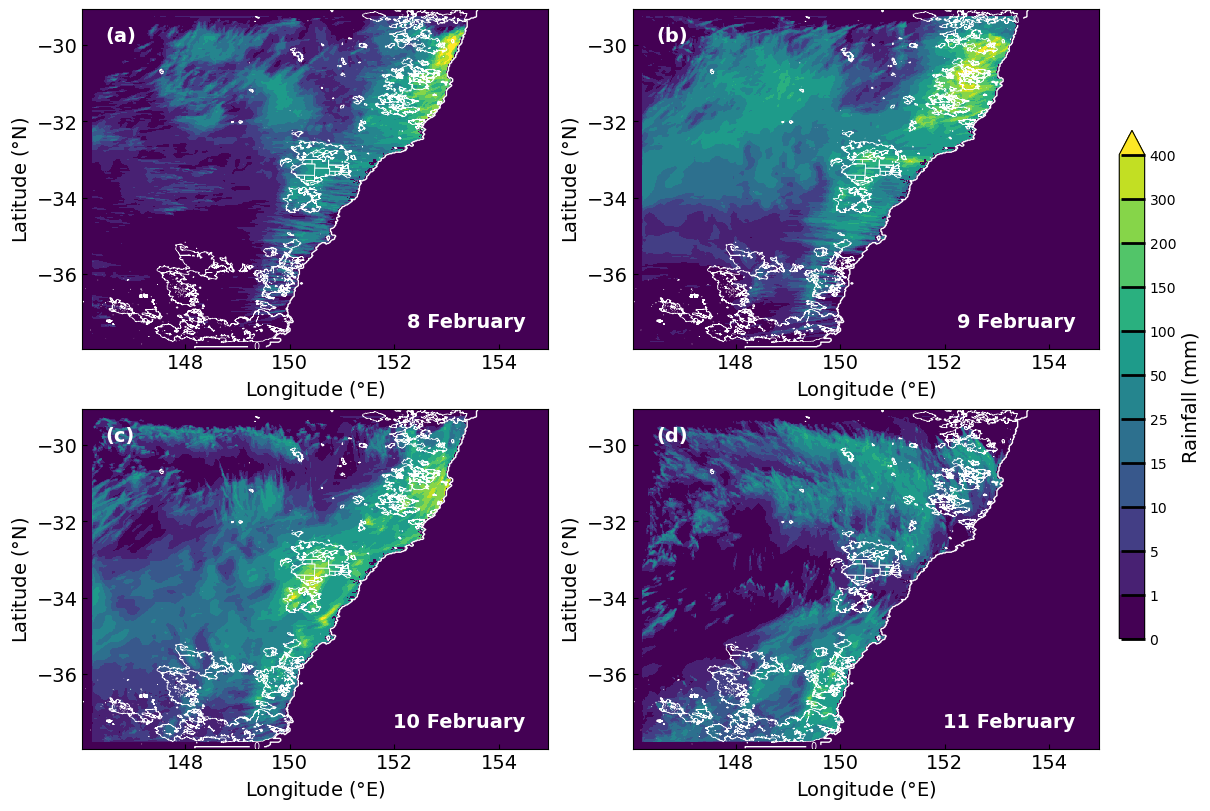

In [12]:
dates = ["2020-02-08", "2020-02-09", "2020-02-10", "2020-02-11"]
titles = ["8 February", "9 February", "10 February", "11 February"]
labels = ['a', 'b', 'c', 'd']
levels = [0, 1, 5, 10, 15, 25, 50, 100, 150, 200, 300, 400]

fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
axes = axes.flatten()

for i, date in enumerate(dates):
    day = pd.Timestamp(date)
    
    #9am the day before to 8am on the day to match AGCD method
    start_time = day - pd.Timedelta(days=1) + pd.Timedelta(hours=9)
    end_time = day + pd.Timedelta(hours=8)
    
    #mm/s to mm/hr, sum
    hourly = da1_local.sel(time=slice(start_time, end_time)) * 3600  # mm/hr
    daily_total = hourly.sum(dim='time', skipna=True)

    im = daily_total.plot(
        ax=axes[i],
        cmap="viridis",
        levels=levels,
        extend='max',
        add_colorbar=False
    )

    contours = sa1.plot.contour(
        ax=axes[i], levels=[0], colors='white', linewidths=1, add_colorbar=False
    )
    axes[i].clabel(contours, fmt='%d', fontsize=7)
    
    #fires to not skew map appearance
    xlim = axes[i].get_xlim()
    ylim = axes[i].get_ylim()
    aspect = axes[i].get_aspect()
    extent_poly = geom.box(xlim[0], ylim[0], xlim[1], ylim[1])
    fires_clipped = fires.clip(extent_poly)
    fires_clipped.boundary.plot(
        ax=axes[i],
        edgecolor='white',
        linewidth=0.5,
        aspect=aspect
    )
    axes[i].set_xlim(xlim)
    axes[i].set_ylim(ylim)
    axes[i].set_aspect(aspect)

    axes[i].set_title("")
    axes[i].text(
        0.05, 0.95, f"({labels[i]})",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='top',
        ha='left',
        color='white'
    )
    axes[i].text(
        0.95, 0.05, f"{titles[i]}",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='bottom',
        ha='right',
        color='white'
    )
    axes[i].set_xlabel("Longitude ($\\degree$E)", fontsize=14)
    axes[i].set_ylabel("Latitude ($\\degree$N)", fontsize=14)
    axes[i].tick_params(axis='both', direction='in', labelsize=14)

cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label("Rainfall (mm)", fontsize=14)
cbar.set_ticks(levels)
cbar.ax.tick_params(axis='y', width=2, direction='in', length=17)

## Model on AGCD resolution

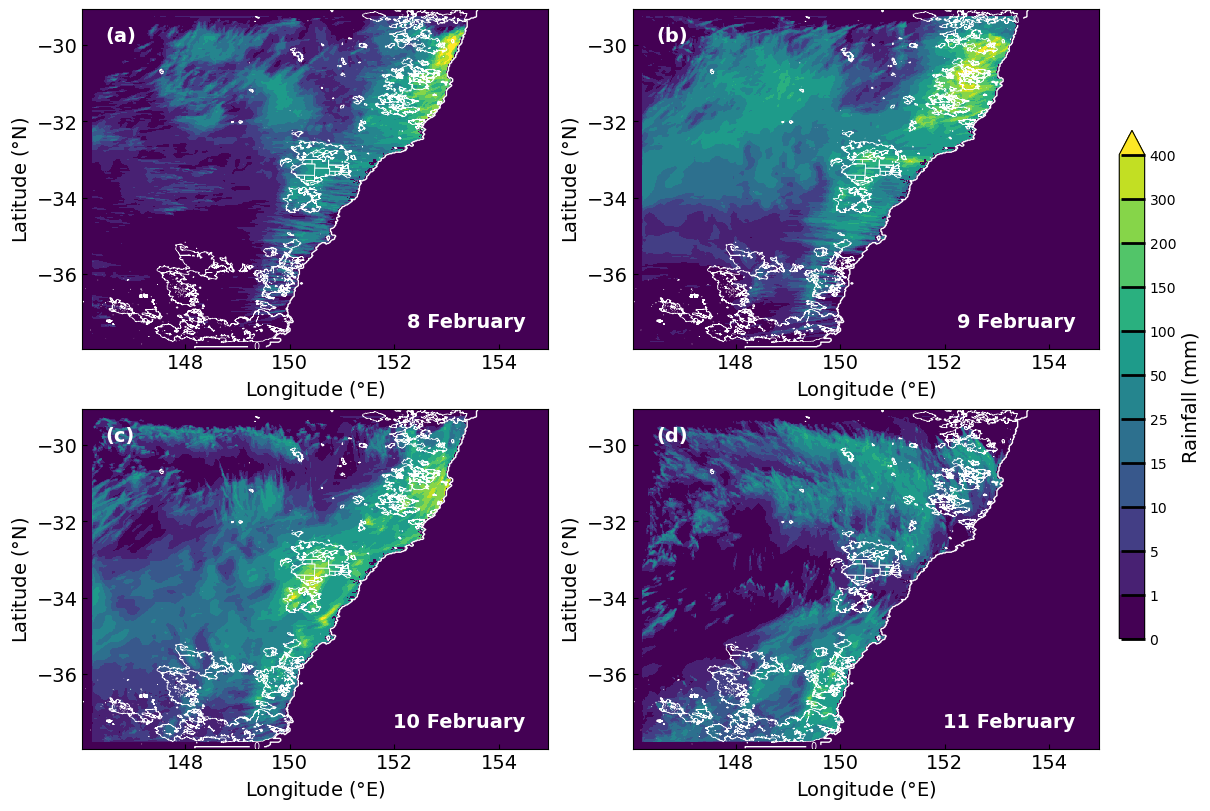

In [19]:
dates = ["2020-02-08", "2020-02-09", "2020-02-10", "2020-02-11"]
titles = ["8 February", "9 February", "10 February", "11 February"]
labels = ['a', 'b', 'c', 'd']
levels = [0, 1, 5, 10, 15, 25, 50, 100, 150, 200, 300, 400]

fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
axes = axes.flatten()

for i, date in enumerate(dates):
    day = pd.Timestamp(date)
    
    # 9am the day before to 8am on the day to match AGCD method
    start_time = day - pd.Timedelta(days=1) + pd.Timedelta(hours=9)
    end_time = day + pd.Timedelta(hours=8)
    
    # (mm/s) to mm/hr, then sum
    hourly = model_clipped.sel(time=slice(start_time, end_time)) * 3600  # mm/hr
    daily_total = hourly.sum(dim='time', skipna=True)

    im = daily_total.plot(
        ax=axes[i],
        cmap="viridis",
        levels=levels,
        extend='max',
        add_colorbar=False
    )

    contours = sa1.plot.contour(
        ax=axes[i], levels=[0], colors='white', linewidths=1, add_colorbar=False
    )
    axes[i].clabel(contours, fmt='%d', fontsize=7)
    
    xlim = axes[i].get_xlim()
    ylim = axes[i].get_ylim()
    aspect = axes[i].get_aspect()
    extent_poly = geom.box(xlim[0], ylim[0], xlim[1], ylim[1])
    fires_clipped = fires.clip(extent_poly)

    fires_clipped.boundary.plot(
        ax=axes[i],
        edgecolor='white',
        linewidth=0.5,
        aspect=aspect
    )

    axes[i].set_xlim(xlim)
    axes[i].set_ylim(ylim)
    axes[i].set_aspect(aspect)

    axes[i].set_title("")
    axes[i].text(
        0.05, 0.95, f"({labels[i]})",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='top',
        ha='left',
        color='white'
    )
    axes[i].text(
        0.95, 0.05, f"{titles[i]}",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='bottom',
        ha='right',
        color='white'
    )
    axes[i].set_xlabel("Longitude ($\\degree$E)", fontsize=14)
    axes[i].set_ylabel("Latitude ($\\degree$N)", fontsize=14)
    axes[i].tick_params(axis='both', direction='in', labelsize=14)

cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label("Rainfall (mm)", fontsize=14)
cbar.set_ticks(levels)
cbar.ax.tick_params(axis='y', width=2, direction='in', length=17)

# this is the plot I have linked with the AGCD one

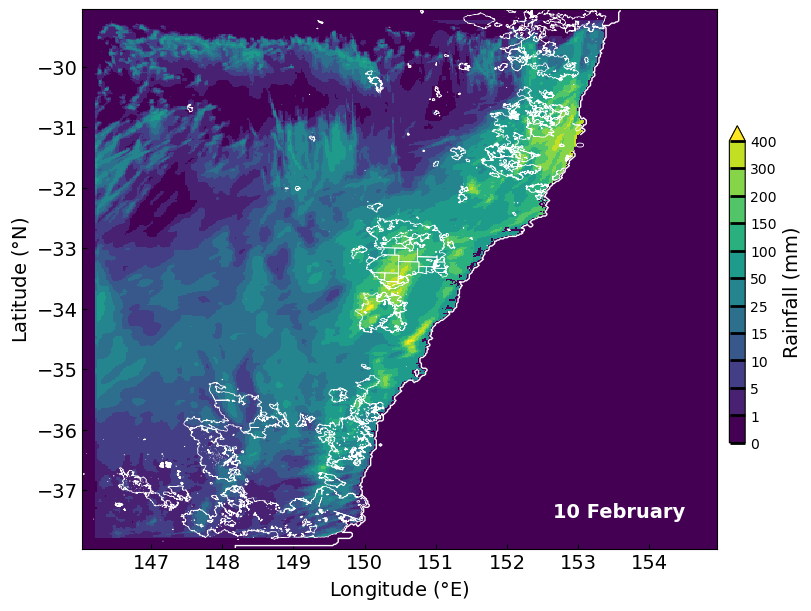

In [20]:

date = "2020-02-10"
title = "10 February"
levels = [0, 1, 5, 10, 15, 25, 50, 100, 150, 200, 300, 400]

fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)

day = pd.Timestamp(date)

# AEST shift to match AGCD
start_time = day - pd.Timedelta(days=1) + pd.Timedelta(hours=9)
end_time = day + pd.Timedelta(hours=8)

# Convert flux (mm/s) to mm/hr, then sum
hourly = model_clipped.sel(time=slice(start_time, end_time)) * 3600  # mm/hr
daily_total = hourly.sum(dim="time", skipna=True)

cmap = mpl.colormaps["viridis"].copy()
cmap.set_bad(color="white")

# Plot rainfall
im = daily_total.plot(
    ax=ax,
    cmap="viridis",
    levels=levels,
    extend="max",
    add_colorbar=False
)

# Overlay surface altitude contours
contours = sa1.plot.contour(
    ax=ax, levels=[0], colors="white", linewidths=1, add_colorbar=False
)
ax.clabel(contours, fmt="%d", fontsize=7)

# Save current extent and aspect
xlim = ax.get_xlim()
ylim = ax.get_ylim()
aspect = ax.get_aspect()

# Clip fires to visible extent
extent_poly = geom.box(xlim[0], ylim[0], xlim[1], ylim[1])
fires_clipped = fires.clip(extent_poly)

# Overlay fire boundaries without changing map shape
fires_clipped.boundary.plot(
    ax=ax,
    edgecolor="white",
    linewidth=0.5,
    aspect=aspect
)

# Restore limits & aspect
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect(aspect)

# Annotations
ax.set_title("")
ax.text(
    0.95, 0.05, f"{title}",
    transform=ax.transAxes,
    fontsize=14,
    fontweight="bold",
    va="bottom",
    ha="right",
    color="white"
)
ax.set_xlabel("Longitude ($\\degree$E)", fontsize=14)
ax.set_ylabel("Latitude ($\\degree$N)", fontsize=14)
ax.tick_params(axis="both", direction="in", labelsize=14)

# Add colorbar
cbar = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.025, pad=0.02)
cbar.set_label("Rainfall (mm)", fontsize=14)
cbar.set_ticks(levels)
cbar.ax.tick_params(axis="y", width=2, direction="in", length=11)
plt.show()
